In [1]:
#!pipenv install blackcellmagic --dev

In [2]:
%load_ext blackcellmagic

In [3]:
import pandas as pd
df = pd.read_csv("daily.csv")

In [4]:
df =df.set_index("Unnamed: 0")
df.columns.values

array(['Total', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'WDF2',
       'WSF2'], dtype=object)

In [5]:
df

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,WDF2,WSF2
Unnamed: 0,,,,,,,,,
2012-10-03,3521.0,0,0,0,189,78,73,10,103
2012-10-04,3475.0,0,0,0,189,83,65,20,94
2012-10-05,3148.0,0,0,0,217,89,57,360,80
2012-10-06,2006.0,0,0,0,239,78,51,20,76
2012-10-07,2142.0,0,0,0,239,78,13,30,54
2012-10-08,3537.0,0,0,0,211,78,19,210,40
2012-10-09,3501.0,0,0,0,161,89,16,170,40
2012-10-10,3235.0,0,0,0,122,83,14,40,40
2012-10-11,3047.0,0,0,0,139,72,13,270,40


In [6]:
import seaborn
import matplotlib.pyplot as plt

In [7]:
print(df["Total"].dtypes)

float64


In [8]:
class CrawtoML:
    import pandas as pd
    import seaborn

    """
    import pandas
    pandas.DataFrame
    """

    def __init__(self, data, target, features):
        self.data = data
        self.target = target
        self.features = features

    def numerics(self):
        numerics = []
        for i in self.features:
            if self.data[i].dtypes in ["int64", "float64"]:
                numerics.append(i)
        self.numeric_columns = numerics
        return self.numeric_columns

    def other_types(self):
        others = [i  for i in self.features if i not in self.numeric_columns ]
        self.other_types = others
        return self.other_types
    
    def __repr__(self):
        return "Target Column: %s \n \
        Feature columns: %s\n \
        Numeric Columns: %s"(
            self.target, self.features, self.numeric_columns
        )
    def correlation_report(self):
        seaborn.heatmap(self.data[self.numeric_columns].corr())
    
    def distribution_report(self):
        seaborn.PairGrid(self.data,x_vars=self.features, y_vars=self.target).map(plt.scatter)
        seaborn.distplot(self.data[self.target])

In [9]:
automl = CrawtoML(
    data=df,
    target="Total",
    features=["PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "AWND", "WDF2", "WSF2"],
)

In [10]:
automl.numerics()

['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'WDF2', 'WSF2']

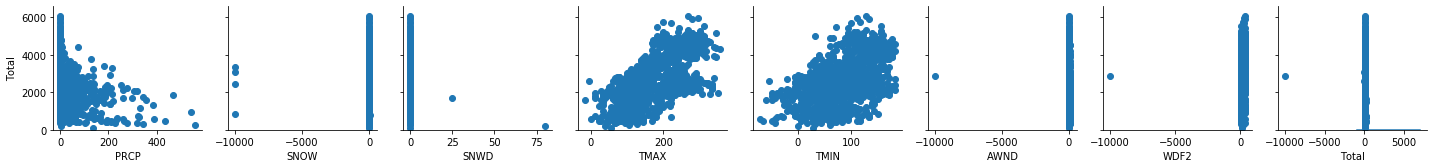

In [11]:
automl.distribution_report()

In [12]:
from scipy.stats import anderson

In [13]:
distribution_types = ['norm','expon','logistic','gumbel']

In [14]:
l = []
for i in distribution_types:
    l.append(anderson(automl.data[automl.numeric_columns[0]], dist=i))

In [15]:
l

[AndersonResult(statistic=189.2992189651368, critical_values=array([0.574, 0.654, 0.784, 0.915, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])),
 AndersonResult(statistic=inf, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])),
 AndersonResult(statistic=2240.16299856351, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5])),
 AndersonResult(statistic=229.52860353312826, critical_values=array([0.471, 0.633, 0.752, 0.872, 1.032]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))]

In [16]:
def distribution_fit(data,numeric_column):
    from scipy.stats import shapiro
    """
    x is a column_name
    """
    shapiro_values = shapiro(data[numeric_column])
    return {"Shapiro_Wilks_Test_Statistic": shapiro_values[0] , "Shapiro_Wilks_p_Value":shapiro_values[1] }

((array([-3.2154319 , -2.95158165, -2.80442994, ...,  2.80442994,
          2.95158165,  3.2154319 ]),
  array([-9999, -9999, -9999, ...,    20,    28,    74])),
 (110.66331165898865, -37.46146616541352, 0.18036488362517583))

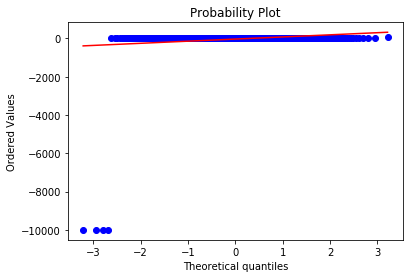

In [17]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
probplot(automl.data[automl.features[1]], plot=plt)

In [18]:
#!pipenv install plotly

In [36]:
automl.numeric_columns[0]

'PRCP'

In [39]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import numpy as np
init_notebook_mode(connected=True)

x = [automl.data[automl.numeric_columns[0]]]

fig = ff.create_distplot(x, [automl.numeric_columns[0]])
iplot(fig, filename='Basic Distplot')